<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task" data-toc-modified-id="Task-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Goal" data-toc-modified-id="Goal-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Features" data-toc-modified-id="Features-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Features</a></span></li><li><span><a href="#Train/test-split" data-toc-modified-id="Train/test-split-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Train/test split</a></span></li></ul></li><li><span><a href="#Dummy-models" data-toc-modified-id="Dummy-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dummy models</a></span><ul class="toc-item"><li><span><a href="#Mean-value" data-toc-modified-id="Mean-value-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Mean value</a></span></li><li><span><a href="#&quot;Nothing-changes&quot;" data-toc-modified-id="&quot;Nothing-changes&quot;-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>"Nothing changes"</a></span></li><li><span><a href="#Simple-tree" data-toc-modified-id="Simple-tree-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Simple tree</a></span></li><li><span><a href="#Look-at-your-data-using-your-own-eyes" data-toc-modified-id="Look-at-your-data-using-your-own-eyes-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Look at your data using your own eyes</a></span></li></ul></li><li><span><a href="#Ensembles" data-toc-modified-id="Ensembles-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ensembles</a></span></li><li><span><a href="#Feature-engineering-for-tree-like-models" data-toc-modified-id="Feature-engineering-for-tree-like-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature engineering for tree-like models</a></span><ul class="toc-item"><li><span><a href="#Holidays" data-toc-modified-id="Holidays-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Holidays</a></span></li><li><span><a href="#Context" data-toc-modified-id="Context-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Context</a></span></li></ul></li><li><span><a href="#Feature-selection" data-toc-modified-id="Feature-selection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature selection</a></span></li></ul></div>

In [ ]:
!pip install sklearn_pandas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
sns.set_palette('muted')
sns.set_color_codes('muted')
sns.set_style('white')
pio.templates.default = "plotly_white"

In [ ]:
%config InlineBackend.figure_format = 'retina'

Seminar plan:
- Ensembles: how to overfit and how not to overfit
- Feature engineering for tree-based methods
- Feature selection (if you engineered too many features)

# Task

Source: https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand#

## Data

Hourly bike rentals in Seoul for 2 years

## Goal

Predict hourly bike rentals for 1 day ahead

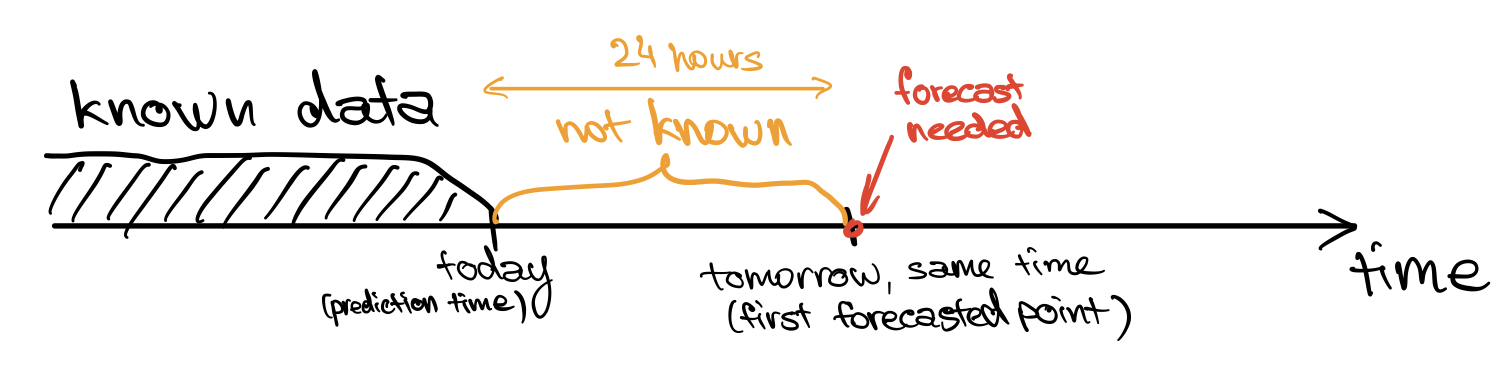

In [ ]:
df = pd.read_csv('../data/SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'])
df['Datetime'] = df.Date + pd.to_timedelta(df.Hour, unit='hours')
df.sample(5)

In [ ]:
df.columns

In [ ]:
fig = px.scatter(data_frame=df, x='Datetime', y='Rented Bike Count')
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True), type="date"))

Actually we have data for 1 year only

## Features

**Discussion**: create features

In [ ]:
df

In [ ]:
data_start = pd.to_datetime('2017-12-13')
features = df\
    .groupby('Hour')\
    .apply(lambda x: x.sort_values('Date').assign(
        target=lambda d: d['Rented Bike Count'].shift(-1),
    ))\
    .reset_index(drop=True)\
    .query('Date >= @data_start')\
    .sort_values(['Date', 'Hour'])\
    .dropna(axis='index', how='any')

In [ ]:
features.loc[features.Hour == 10, ['Date', 'Hour', 'Rented Bike Count', 'target']][:4]

In [ ]:
features.isna().any()

In [ ]:
features.sample(4)

## Train/test split

In [ ]:
features.Date.describe(datetime_is_numeric=True)

In [ ]:
train = features.Date < pd.to_datetime('2018-09-11')
test = features.Date >= pd.to_datetime('2018-09-11')

In [ ]:
X_train, X_test = features.loc[train, features.columns != 'target'], features.loc[test, features.columns != 'target']
y_train, y_test = features.loc[train, 'target'], features.loc[test, 'target']

# Dummy models

## Mean value

In [ ]:
from sklearn.dummy import DummyRegressor
dummy = DummyRegressor(strategy='mean').fit(X_train, y_train)

In [ ]:
dummy.predict(X_train)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [ ]:
mean_squared_error(y_true=y_train, y_pred=dummy.predict(X_train), squared=False)

In [ ]:
mean_absolute_percentage_error(y_true=y_train, y_pred=dummy.predict(X_train))

***Q***: why MAPE is that huge?

## "Nothing changes"

***Task***: evaluate the quality of the 'previous day' model

In [ ]:
y_pred_train = X_train['Rented Bike Count']


In [ ]:
y_pred_test = X_test['Rented Bike Count']


## Simple tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dummy_tree = DecisionTreeRegressor(max_depth=3).fit(X=X_train[['Hour']], y=y_train)

In [ ]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(25, 10), dpi=200)
plot_tree(dummy_tree, feature_names=['hour'], filled=True, ax=fig.gca(), fontsize='small');

In [ ]:
dummy_tree.predict(X_train[['Hour']])

In [ ]:
y_pred_train = dummy_tree.predict(X_train[['Hour']])
print('Train RMSE %.2f' % mean_squared_error(y_true=y_train, y_pred=y_pred_train, squared=False))
print('Train MAPE %.2f%%' % mean_absolute_percentage_error(y_true=y_train.clip(lower=1), y_pred=y_pred_train))

In [ ]:
y_pred_test = dummy_tree.predict(X_test[['Hour']])
print('Test RMSE %.2f' % mean_squared_error(y_true=y_test, y_pred=y_pred_test, squared=False))
print('Test MAPE %.2f%%' % mean_absolute_percentage_error(y_true=y_test.clip(lower=1), y_pred=y_pred_test))

## Look at your data using your own eyes

In [ ]:
fig = go.Figure(data=[
    go.Scatter(x=X_train['Datetime'], y=y_train, name='ground truth'),
    go.Scatter(
        x=X_train['Datetime'], 
        y=dummy_tree.predict(X_train[['Hour']]),
        name='forecast',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty'
    ),
], layout=go.Layout(xaxis=dict(rangeslider=dict(visible=True), type="date")))
fig.show()

# Ensembles

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X_train.columns

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
rf = make_pipeline(
    ColumnTransformer([
        ('selector', 'passthrough', ['Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
                                     'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
                                     'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)'
                                    ]),
        ('onehotencoder', OneHotEncoder(handle_unknown='ignore'), ['Seasons', 'Holiday', 'Functioning Day'])
    ]), 
    RandomForestRegressor(n_estimators=500)
).fit(X_train, y_train)

In [ ]:
y_pred_train = rf.predict(X_train)

In [ ]:
print('Train RMSE %.2f' % mean_squared_error(y_true=y_train, y_pred=y_pred_train, squared=False))
print('Train MAPE %.2f%%' % mean_absolute_percentage_error(y_true=y_train.clip(lower=1), y_pred=y_pred_train))

In [ ]:
y_pred_test = rf.predict(X_test)
print('Test RMSE %.2f' % mean_squared_error(y_true=y_test, y_pred=y_pred_test, squared=False))
print('Test MAPE %.2f%%' % mean_absolute_percentage_error(y_true=y_test.clip(lower=1), y_pred=y_pred_test))

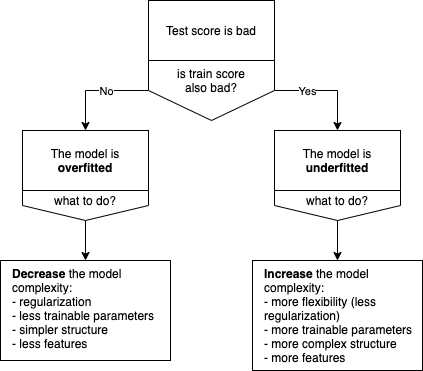

***Q***: what is the state of our model?

If you're curious, you can compare train and test behavior of the model:

In [ ]:
fig = go.Figure(data=[
    go.Scatter(x=X_train['Datetime'], y=y_train, name='ground truth'),
    go.Scatter(
        x=X_train['Datetime'], 
        y=y_pred_train,
        name='forecast',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty'
    ),
], layout=go.Layout(xaxis=dict(rangeslider=dict(visible=True), type="date")))
fig.show()

In [ ]:
fig = go.Figure(data=[
    go.Scatter(x=X_test['Datetime'], y=y_test, name='ground truth'),
    go.Scatter(
        x=X_test['Datetime'], 
        y=y_pred_test,
        name='forecast',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty'
    ),
], layout=go.Layout(xaxis=dict(rangeslider=dict(visible=True), type="date")))
fig.show()

# Feature engineering for tree-like models

## Holidays

In [ ]:
features = df\
    .groupby('Hour')\
    .apply(lambda x: x.sort_values('Date').assign(
        target=lambda d: d['Rented Bike Count'].shift(-1),
        target_season=lambda d: d['Seasons'].shift(-1),
        target_holiday=lambda d: d['Holiday'].shift(-1),
        target_func_day=lambda d: d['Functioning Day'].shift(-1),
    ))\
    .reset_index(drop=True)\
    .query('Date >= @data_start')\
    .sort_values(['Date', 'Hour'])\
    .dropna(axis='index', how='any')

In [ ]:
X_train, X_test = features.loc[train, features.columns != 'target'], features.loc[test, features.columns != 'target']
y_train, y_test = features.loc[train, 'target'], features.loc[test, 'target']

In [ ]:
X_train.columns

***Task***: add data about holidays to the model

Morale: holidays are important for time series data

## Context

In [ ]:
features = df\
    .groupby('Hour')\
    .apply(lambda x: x.sort_values('Date').assign(
        target=lambda d: d['Rented Bike Count'].shift(-1),
        target_season=lambda d: d['Seasons'].shift(-1),
        target_holiday=lambda d: d['Holiday'].shift(-1),
        target_func_day=lambda d: d['Functioning Day'].shift(-1),
        target_yesterday=lambda d: d['Rented Bike Count'].shift(1),
        t_yesterday=lambda d: d['Temperature(°C)'].shift(1),
        humidity_yesterday=lambda d: d['Humidity(%)'].shift(1)
    ))\
    .reset_index(drop=True)\
    .query('Date >= @data_start')\
    .sort_values(['Date', 'Hour'])\
    .dropna(axis='index', how='any')

In [ ]:
X_train, X_test = features.loc[train, features.columns != 'target'], features.loc[test, features.columns != 'target']
y_train, y_test = features.loc[train, 'target'], features.loc[test, 'target']

***Q***: how to understand whether the change in metrics was not a random fluctuation?

# Feature selection

Main logic: "if the feature is not useful, then it can be removed"

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
X_fselect = rf.named_steps['columntransformer'].transform(X_train)

In [ ]:
X_fselect.shape

In [ ]:
from sklearn.base import clone
from tqdm import tqdm

results = []
for feature_id in tqdm(range(X_fselect.shape[1])):
    feature_errors = []
    X_for_feature = X_fselect.copy()
    X_for_feature[:, feature_id] = np.random.choice(X_for_feature[:, feature_id], size=len(X_for_feature))
    for train_index, test_index in tqdm(tscv.split(X_for_feature)):
        X_train_fselect, X_test_fselect = X_for_feature[train_index], X_for_feature[test_index]
        y_train_fselect, y_test_fselect = y_train.iloc[train_index], y_train.iloc[test_index]
        estimator = clone(rf.named_steps['randomforestregressor'])
        estimator.fit(X_train_fselect, y_train_fselect)
        y_test_pred_fselect = estimator.predict(X_test_fselect)
        feature_errors.append(dict(
            feature_id=feature_id, 
            rmse=mean_squared_error(y_test_fselect, y_test_pred_fselect, squared=False),
            mape=mean_absolute_percentage_error(y_test_fselect.clip(lower=1), y_test_pred_fselect)
        ))
    results.extend(feature_errors)

In [ ]:
px.scatter(data_frame=pd.DataFrame(results), x='feature_id', y='rmse')